In [ ]:
!pip install unstructured[inference]
!pip install pytesseract

In [ ]:
!pip install unstructured[local-inference]

In [ ]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

In [ ]:
!apt-get install poppler-utils

In [ ]:
pip install pdfminer

In [ ]:
!pip install pillow_heif

In [ ]:
!pip install pdf2image

In [ ]:
!pip install pdfminer.six --upgrade

In [ ]:
pip install unstructured

In [ ]:
path = "/content/"

In [ ]:
from unstructured.partition.pdf import partition_pdf
# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=path + "wildfire_stats.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [ ]:
# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

In [ ]:
len(tables), len(texts)

(2, 5)

In [ ]:
tables[0]

'2018 2019 2020 Number of Fires (thousands) Federal 12.5 10.9 14.4 FS 5.6 5.3 6.7 DOI 7.0 5.3 7.6 2021 14.0 6.2 7.6 11.7 5.9 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 Acres Burned (millions) Federal 4.6 FS 2.3 DOI 2.3 50.5 3.1 0.6 2.3 59.0 7.1 4.8 2.3 59.0 5.2 4.1 1.0 69.0 4.0 1.9 2.1 Other <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 Total 8.8 4.7 10.1 7.1 <0.1 3.6 7.6'

In [ ]:
texts[0]

'a. aa = Informing the legislative debate since 1914 Congressional Research Service\n\nUpdated June 1, 2023\n\nWildfire Statistics\n\nWildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.\n\nFigure 1. Annual Wildfires and Acres Burned, 1993-2022\n\nAcres b

In [ ]:
!pip install langchain

In [ ]:
!pip install langchain_community

In [ ]:
!pip install openai

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [ ]:
import openai
import os

# find API key in console at https://platform.openai.com/account/api-keys

os.environ["OPENAI_API_KEY"] = "sk-"
openai.api_key = os.environ["OPENAI_API_KEY"]

# langsmith traces

os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="langchain-multimodal-pdf"

In [ ]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
# Apply to text
# Typically this is reccomended only if you have large text chunks
text_summaries = texts # Skip it

# Apply to tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [ ]:
len(table_summaries)

2

In [ ]:
table_summaries[0]

'The table provides data on the number of fires and acres burned from 2018 to 2021. The fires are categorized as Federal, FS, DOI, Other, and Nonfederal. The total number of fires increased from 58.1 thousand in 2018 to 69.0 thousand in 2021. The acres burned also increased from 8.8 million in 2018 to 7.6 million in 2021. The highest number of fires and acres burned were recorded in 2021 under the Nonfederal category with 57.2 thousand fires and 3.6 million acres burned.'

In [ ]:
table_summaries[1]

'The table provides data on the number of structures burned each year from 2019 to 2022, with a significant increase in 2020 at 17,904 structures. The percentage of these structures that were residences fluctuated between 46% and 60%. The highest percentage of residences burned was in 2021, while the lowest was in 2019 and 2022, both at 46%.'

In [ ]:
ipath = "/content/figures"

In [ ]:
import io
import os
import base64
import numpy as np
from PIL import Image
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage

def encode_image(image_path):
    ''' Getting the base64 string '''
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def image_summarize(img_base64,prompt):
    ''' Image summary '''
    chat = ChatOpenAI(model="gpt-4o",
                      max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text":prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}"
                        },
                    },
                ]
            )
        ]
    )
    return msg.content

# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = "Describe the image in detail. Be specific about graphs, such as bar plots."

# Read images, encode to base64 strings
for img_file in sorted(os.listdir(ipath)):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(ipath, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image,prompt))

In [ ]:

len(img_base64_list)

5

In [ ]:
img_base64_list[1]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiApQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1Pw74d0i78PWU89hDJK8eWYg5JzWp/wAIroX/AEDIPyNHhX/kVtO/65D+Zq/fahZ6bb/aL65it4c43ysFGfqaAKH/AAiuhf8AQMg/I0f8IroX/QMg/I1PY6/pGpO6WOpWtwyDcwilDYHqcVbtrqC8gWe2mSaJujocg0AZv/C

In [ ]:
len(image_summaries) #we have five images

5

In [ ]:
image_summaries[1]

'The image is a chart depicting data on the number of fires and the acreage burned over a period from 1993 to 2022. The chart has two vertical axes: the left axis measures the number of fires in thousands, ranging from 0 to 120, and the right axis measures the acres burned in millions, ranging from 0 to 12.\n\nKey features of the chart:\n\n1. **Bar Plot (Gray Area) - Acres Burned:**\n   - The gray area represents the number of acres burned in millions.\n   - The height of the gray area varies over the years, indicating fluctuations in the number of acres burned.\n   - Notable peaks occur in the years around 2007, 2012, and 2020, where the acres burned exceeded 8 million.\n   - The lowest values appear in the early 2000s and around 2014, where the acres burned dropped below 4 million.\n\n2. **Line Plot (Red Line) - Number of Fires:**\n   - The red line represents the number of fires in thousands.\n   - The number of fires starts at approximately 80,000 in 1993, rises to nearly 100,000 i


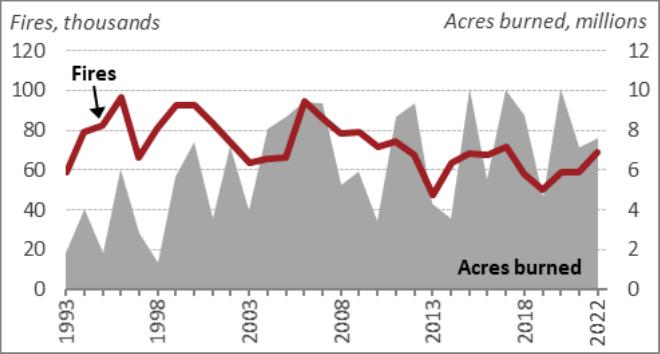

In [ ]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

plt_img_base64(img_base64_list[1])


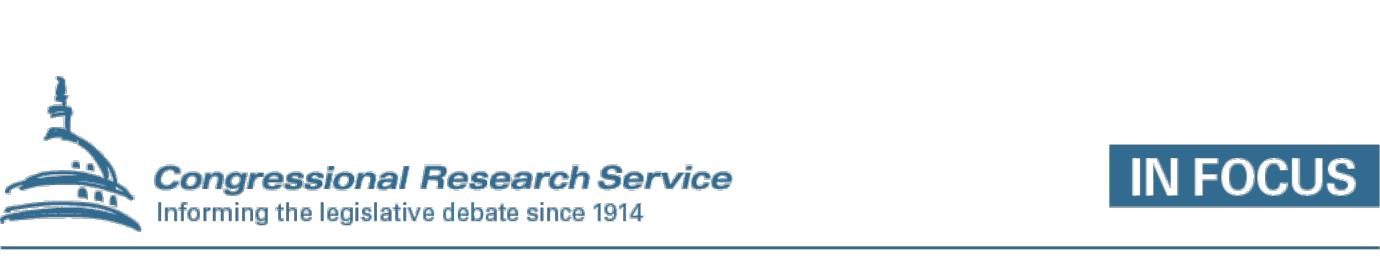

In [ ]:
plt_img_base64(img_base64_list[0])

Add to vectorstore

In [ ]:
pip install chromadb

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [ ]:
!pip install tiktoken

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

In [ ]:
len(doc_ids), len(summary_texts)

(5, 5)

In [ ]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in img_base64_list]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, img_base64_list)))

In [ ]:
len(img_ids), len(summary_img)

(5, 5)

In [ ]:
summary_img[1]

Document(page_content='The image is a chart depicting data on the number of fires and the acreage burned over a period from 1993 to 2022. The chart has two vertical axes: the left axis measures the number of fires in thousands, ranging from 0 to 120, and the right axis measures the acres burned in millions, ranging from 0 to 12.\n\nKey features of the chart:\n\n1. **Bar Plot (Gray Area) - Acres Burned:**\n   - The gray area represents the number of acres burned in millions.\n   - The height of the gray area varies over the years, indicating fluctuations in the number of acres burned.\n   - Notable peaks occur in the years around 2007, 2012, and 2020, where the acres burned exceeded 8 million.\n   - The lowest values appear in the early 2000s and around 2014, where the acres burned dropped below 4 million.\n\n2. **Line Plot (Red Line) - Number of Fires:**\n   - The red line represents the number of fires in thousands.\n   - The number of fires starts at approximately 80,000 in 1993, ris

In [ ]:
# Retrieve
docs = retriever.invoke(
    "What is the change in wild fires from 1993 to 2022?"
)

In [ ]:
len(docs)

4

In [ ]:
from base64 import b64decode
def split_image_text_types(docs):
    ''' Split base64-encoded images and texts '''
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc.encode('utf-8')) # Encode the string to bytes before decoding
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }
docs_by_type = split_image_text_types(docs)


In [ ]:
plt_img_base64(docs_by_type["images"][0])

In [ ]:
len(docs_by_type["images"])

2

In [ ]:
len(docs_by_type["texts"])

2

In [ ]:
docs_by_type["texts"][0]

'2018 2019 2020 Number of Fires (thousands) Federal 12.5 10.9 14.4 FS 5.6 5.3 6.7 DOI 7.0 5.3 7.6 2021 14.0 6.2 7.6 11.7 5.9 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 Acres Burned (millions) Federal 4.6 FS 2.3 DOI 2.3 50.5 3.1 0.6 2.3 59.0 7.1 4.8 2.3 59.0 5.2 4.1 1.0 69.0 4.0 1.9 2.1 Other <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 Total 8.8 4.7 10.1 7.1 <0.1 3.6 7.6'

In [ ]:
docs_by_type["texts"][1]

'Figure 2. Top Five Years with Largest Wildfire Acreage Burned Since 1960\n\nTable 1. Annual Wildfires and Acres Burned'

RAG

In [ ]:

from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    return [
        HumanMessage(
            content=[
                {"type": "text", "text": f"""Answer the question based only on the following context, which can include text, tables, and the below image:
Question: {dict["question"]}

Text and tables:
{format_texts}
"""},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{dict['context']['images'][0]}"}},
            ]
        )
    ]

model = ChatOpenAI(temperature=0, model="gpt-4", max_tokens=1024)

# RAG pipeline
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke(
    "What is the change in wild fires from 1993 to 2022?"
)

InternalServerError: Error code: 500 - {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_989778658ab4d726c4944eded03f4e0d in your email.)', 'type': 'server_error', 'param': None, 'code': None}}